# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!

- 🤝 Breakout Room #2:
  1. Evaluating the LangGraph Application with LangSmith
  2. Adding Helpfulness Check and "Loop" Limits
  3. LangGraph for the "Patterns" of GenAI

# 🤝 Breakout Room #1

## Part 1: LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effectively allowing us to recreate application flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies


## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [3]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

In [2]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE7 - LangGraph - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain-community/tree/main/libs/community) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Tavily Search Results](https://github.com/langchain-ai/langchain-community/blob/main/libs/community/langchain_community/tools/tavily_search/tool.py)
- [Arxiv](https://github.com/langchain-ai/langchain-community/blob/main/libs/community/langchain_community/tools/arxiv/tool.py)

#### 🏗️ Activity #1:

Please add the tools to use into our toolbelt.

> NOTE: Each tool in our toolbelt should be a method.

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun

tavily_tool = TavilySearchResults(max_results=5)

tool_belt = [
    tavily_tool,
    ArxivQueryRun(),
]

/var/folders/7x/87_dc5wd7b93v98ckb_86wj00000gn/T/ipykernel_61827/1203815797.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [5]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [6]:
model = model.bind_tools(tool_belt)

#### ❓ Question #1:

How does the model determine which tool to use?

##### ✅ Answer # 1:
Through "bind_tools" method, the tools are passed to models as context for each inference. Based on user query, tools' descriptio and schema, model is able to pick a tool that can possibly answer user query.

## Task 4: Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

In [7]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

## Task 5: It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

In [8]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

tool_node = ToolNode(tool_belt)

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `tool_node` is a node which can call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [9]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [10]:
uncompiled_graph.set_entry_point("agent")

![image](https://i.imgur.com/wNixpJe.png)

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [11]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

Let's visualize what this looks like.

![image](https://i.imgur.com/8ZNwKI5.png)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [12]:
uncompiled_graph.add_edge("action", "agent")

Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

All that's left to do now is to compile our workflow - and we're off!

In [13]:
simple_agent_graph = uncompiled_graph.compile()

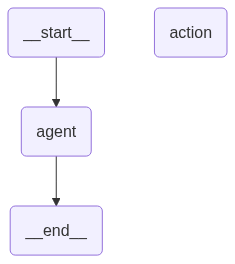

In [14]:
simple_agent_graph

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle?

If not, how could we impose a limit to the number of cycles?

#### ✅ answer # 2:
- No
- We could impose limit to the number of cycles by
    1. check number of messages in input state in the conditional edge (should_continue) and go to END if reaches limit, or continue
    2. set recusion limit when we compile the graph: 
    ```
    graph = uncompiled_graph.compile(
    recursion_limit=5  # Maximum 5 cycles
    )
    ```
    3. add a counter field in state to keep track of number of cycles and check the counter in conditional edge, go to END if reaches limit, or continue



## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [23]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="Who is the current captain of the Winnipeg Jets?")]}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_T5oFVGFWrhWDEU0V2JRArQty', 'function': {'arguments': '{"query":"current captain of the Winnipeg Jets"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 162, 'total_tokens': 185, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BryYTNPtwpQIRsepbQwWnRdTTkoiw', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--14d03157-901f-4028-89a5-20afc69d603d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current captain of the Winnipeg Jets'}, 'id': 'call_T5oFVGFWrhWDEU0V2JRArQty', 'type': 

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [25]:
from langchain_core.messages import HumanMessage
import json


inputs = {"messages" : [HumanMessage(content="First Search Arxiv for the QLoRA paper, then search each of the authors to find out their latest Tweet using Tavily! Do these two sequentially!")]}

async for chunk in simple_agent_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          for message in values["messages"]:
              print("\n\n")
              print(f"Tool Used: {message.name}")
              print(f"Tool output: {message.content}")

        else:
          print(values["messages"])

        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IXF59yNYws72m5hcmebZuUYQ', 'function': {'arguments': '{"query": "QLoRA"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_wSSj43hHZfAhJye9KobuPdHB', 'function': {'arguments': '{"query": "latest Tweet by author of QLoRA paper"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 185, 'total_tokens': 243, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-Bs0GWPjWtdQTLFmCI3FR5aHpYnlxi', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--81a0c006-3b51-44b9-a86a-bcc59988f94c-0', tool_calls=[{'name': 'arxiv'

#### 🏗️ Activity #2:

Please write out the steps the agent took to arrive at the correct answer.

#### ✅ answer 2 
1. graph is invoked with user query, this goes to `agent node`
2. `agent node` invokes llm with user query and tools it have and responds with 2 tool calls (both arxiv and tavily) and the right arguments to call tools. 
3. conditional edge decides to continue to `action node`
4. `action node` executes the both tools in parallel and output the tool call response to `agent node`.
5. `agent node` invoke llm with original question + tool call result, llm output has no tool_calls this time
6. condition edge routes to END

note: this agent behavior is wrong. It shouldn't output two tools in the first step, which causes the tools being executed in parallel. GPT4.1 nano is less ...smarter? and the agent planning step is very IMPORTANT. 

# 🤝 Breakout Room #2

## Part 1: LangSmith Evaluator

### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [26]:
def convert_inputs(input_object):
  return {"messages" : [HumanMessage(content=input_object["question"])]}

def parse_output(input_state):
  return input_state["messages"][-1].content

agent_chain_with_formatting = convert_inputs | simple_agent_graph | parse_output

In [27]:
agent_chain_with_formatting.invoke({"question" : "What is RAG?"})

"RAG can refer to different concepts depending on the context. Could you please specify whether you're asking about RAG in the context of project management, machine learning, or another field?"

### Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]
```

#### 🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions.

In [28]:
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]

Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [29]:
from langsmith import Client

client = Client()

dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset - {uuid4().hex[0:8]}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers,
    dataset_id=dataset.id,
)

{'example_ids': ['bb043b2d-bea1-4a62-92ec-2994438e59f8',
  'e22b673e-a311-4acd-abb2-21e88ef73a86',
  'aca3fb1e-c166-4f4f-a7bc-6b506cfcfba3',
  '12db2368-d187-421c-b4f7-b8a328be08c7',
  'd7dd8145-8e86-4038-ba1c-6edc909234fa',
  'd5b564c8-84ba-4f03-8ef4-19f5695567ce'],
 'count': 6}

#### ❓ Question #3:

How are the correct answers associated with the questions?

> NOTE: Feel free to indicate if this is problematic or not




#### ✅ answer #3
> The questions and answers are associated by array position/index. If the questions are reordered, then the associations will break. No clear connection between question and answer. Better to zip each question and answer pair together. 

### Task 2: Adding Evaluators

Now we can add a custom evaluator to see if our responses contain the expected information.

We'll be using a fairly naive exact-match process to determine if our response contains specific strings.

In [30]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

#### ❓ Question #4:

What are some ways you could improve this metric as-is?

> NOTE: Alternatively you can suggest where gaps exist in this method.

#### ✅ answer #4 
1. use case-insensitive matching: normalize both phrase and prediction to lower caese 
2. use fuzzy match to avoid exact string match being too rigid (eg. "optimizer" in "optimizers" = False)
3. use partial scoring, sum matched ones/all to get a percentage as the score

Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [30]:
experiment_results = client.evaluate(
    agent_chain_with_formatting,
    data=dataset_name,
    evaluators=[must_mention],
    experiment_prefix=f"Search Pipeline - Evaluation - {uuid4().hex[0:4]}",
    metadata={"version": "1.0.0"},
)

View the evaluation results for experiment: 'Search Pipeline - Evaluation - eaa4-2b6f1d54' at:
https://smith.langchain.com/o/9522861f-8e1e-4a62-8c0d-a84097b261bc/datasets/8151a743-bb32-4e3c-9e9c-65fc738454ed/compare?selectedSessions=f9f2165a-f3d2-4db9-b74f-ee605ef90aba




0it [00:00, ?it/s]

In [25]:
experiment_results

<ExperimentResults RAG Pipeline - Evaluation - cea5-5f13aecb>

## Part 2: LangGraph with Helpfulness:

### Task 3: Adding Helpfulness Check and "Loop" Limits

Now that we've done evaluation - let's see if we can add an extra step where we review the content we've generated to confirm if it fully answers the user's query!

We're going to make a few key adjustments to account for this:

1. We're going to add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop.
2. We'll add to our existing conditional edge to obtain the behaviour we desire.

First, let's define our state again - we can check the length of the state object, so we don't need additional state for this.

In [31]:
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

Now we can set our graph up! This process will be almost entirely the same - with the inclusion of one additional node/conditional edge!

#### 🏗️ Activity #5:

Please write markdown for the following cells to explain what each is doing.

##### YOUR MARKDOWN HERE
1. create empty graph
2. add `agent node` which will call model. This model has tools bind to it.
3. add `tool node` to graph, which will execute tools in parallel if multiple tools are requested in input state.

In [35]:
graph_with_helpfulness_check = StateGraph(AgentState)

graph_with_helpfulness_check.add_node("agent", call_model)
graph_with_helpfulness_check.add_node("action", tool_node)

##### YOUR MARKDOWN HERE

graph start with `agent node`

In [36]:
graph_with_helpfulness_check.set_entry_point("agent")

##### YOUR MARKDOWN HERE

- defined conditional edge `tool_call_or_helpful` 
- it first looks at if there is tool_call in last message in the state, if yes, it goes to `action node`
- if no tool_call and if messages > 10, meaning agent and tool together got called more than 10 times, will go to END directly.
- if no tool_call and messages <=10, create helpfulness chain to use llm to evaluate if the  final response is useufl in answering the initial query. If yes, go to END, otherwise go to `continue` node


problem: this conditional edge doesn't prevent infinite loop between `agent` and `action`, so the message counter is not used. We should move message counter condition to top to prevent infinite loop.

In [32]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def tool_call_or_helpful(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  initial_query = state["messages"][0]
  final_response = state["messages"][-1]

  if len(state["messages"]) > 10:
    return "END"

  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. Please indicate helpfulness with a 'Y' and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  helpfullness_prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4.1-mini")

  helpfulness_chain = helpfullness_prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    return "end"
  else:
    return "continue"

#### 🏗️ Activity #4:

Please write what is happening in our `tool_call_or_helpful` function!

##### YOUR MARKDOWN HERE
add tool_call_or_helpful as conditional edge that goes out from `agent node`. 
it can go to `action node`, `agent node` and END

In [37]:
graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    tool_call_or_helpful,
    {
        "continue" : "agent",
        "action" : "action",
        "end" : END
    }
)

##### YOUR MARKDOWN HERE
from `action node` we can transition to `agent node`

In [38]:
graph_with_helpfulness_check.add_edge("action", "agent")

##### YOUR MARKDOWN HERE
compile graph!

In [39]:
agent_with_helpfulness_check = graph_with_helpfulness_check.compile()

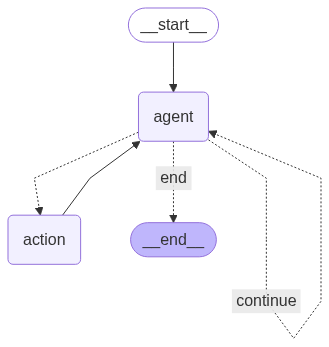

In [40]:
agent_with_helpfulness_check

##### YOUR MARKDOWN HERE
- invoke graph with user question and output from each node as it completes
- print the current node we are at, and the ouput newly added message from the node 


In [33]:
inputs = {"messages" : [HumanMessage(content="Related to machine learning, what is LoRA? Also, who is Tim Dettmers? Also, what is Attention?")]}

async for chunk in agent_with_helpfulness_check.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_S5G2AZ7d5P4QtyVOXhZgukAQ', 'function': {'arguments': '{"query": "LoRA machine learning"}', 'name': 'arxiv'}, 'type': 'function'}, {'id': 'call_7mCqhC6h1fVzg6OmguOK3SCv', 'function': {'arguments': '{"query": "Tim Dettmers"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_Pbd1crDnejnWhUG4tQApbKs4', 'function': {'arguments': '{"query": "Attention mechanism in machine learning"}', 'name': 'arxiv'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 177, 'total_tokens': 249, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bqmw8UIAH9mBzENPbW2jJw4sXbatl'

### Task 4: LangGraph for the "Patterns" of GenAI

Let's ask our system about the 4 patterns of Generative AI:

1. Prompt Engineering
2. RAG
3. Fine-tuning
4. Agents

In [41]:
patterns = ["prompt engineering", "RAG", "fine-tuning", "LLM-based agents"]

In [42]:
for pattern in patterns:
  what_is_string = f"What is {pattern} and when did it break onto the scene??"
  inputs = {"messages" : [HumanMessage(content=what_is_string)]}
  messages = agent_with_helpfulness_check.invoke(inputs)
  print(messages["messages"][-1].content)
  print("\n\n")

Prompt engineering is the process of designing and refining input prompts to effectively communicate with AI language models, such as GPT-3 and GPT-4, to elicit desired responses. It involves crafting prompts that are clear, specific, and contextually rich to improve the quality, relevance, and accuracy of the AI's outputs.

Prompt engineering has gained prominence with the rise of large language models (LLMs) around 2020-2021. As these models became more capable and widely accessible, users and developers recognized the importance of carefully designing prompts to maximize their utility. The practice has since evolved into a specialized skill, often considered a key aspect of working with AI in various applications, from chatbots to content generation.

Would you like more detailed information on its history or specific techniques?



RAG, which stands for Retrieval-Augmented Generation, is a technique in natural language processing that combines pre-trained language models with infor